# Data Slopes

Analisi di una giornata sullo snowboard

In [1]:
## import librerie

## generiche
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

## per grafici
import matplotlib.pyplot as plt
import seaborn as sns

## filtra_intersezioni
import shapely
from shapely.geometry import LineString


In [2]:
## creazione df

df1= pd.read_csv("data/gps-22-12-2024.csv",
    usecols=[0, 1, 2, 3, 6 ,7], 
    names=["unixtime", "latitudine", "longitudine", "altitudine", "precisione_orizzontale", "precisione_verticale"] ## 
    )

df1['unixtime'] = df1['unixtime'].round(0)

## righe duplicate in unixtime
df1 = df1[df1.duplicated(subset="unixtime", keep='first') == False].reset_index(drop=True) 

## finestra temporale utile
df1 = df1[(df1['unixtime'] > 1734859000) & (df1['unixtime'] < 1734878750)].reset_index(drop=True) 

## inserimento colonna per dati geospaziali
gdf1= gpd.GeoDataFrame(
    df1, 
    geometry= gpd.points_from_xy(df1['longitudine'], df1['latitudine']),
    crs= "EPSG:4326"  ## le coordinate usano gradi
)

gdf1 = gdf1.to_crs("EPSG:3857")


In [3]:
## creazione df ddi supporto

df_salite= pd.read_csv("data/salite.csv")
df_discese= pd.read_csv("data/discese.csv")

df_stato = pd.concat([df_salite, df_discese])
df_stato = df_stato.sort_values(by='unixtime_start')



In [4]:
## magic numbers

prezzo_skipass= 33.00



 ## Il dataset originale

 Composto da 3300+ punti gps di cui sono noti:

- latitudine
- longitudine
- altezza in metri sul livello del mare
- precisione orizzontale
- precisone verticale

Presenta le solite anomalie di dati gps: jitter e valori anomali 

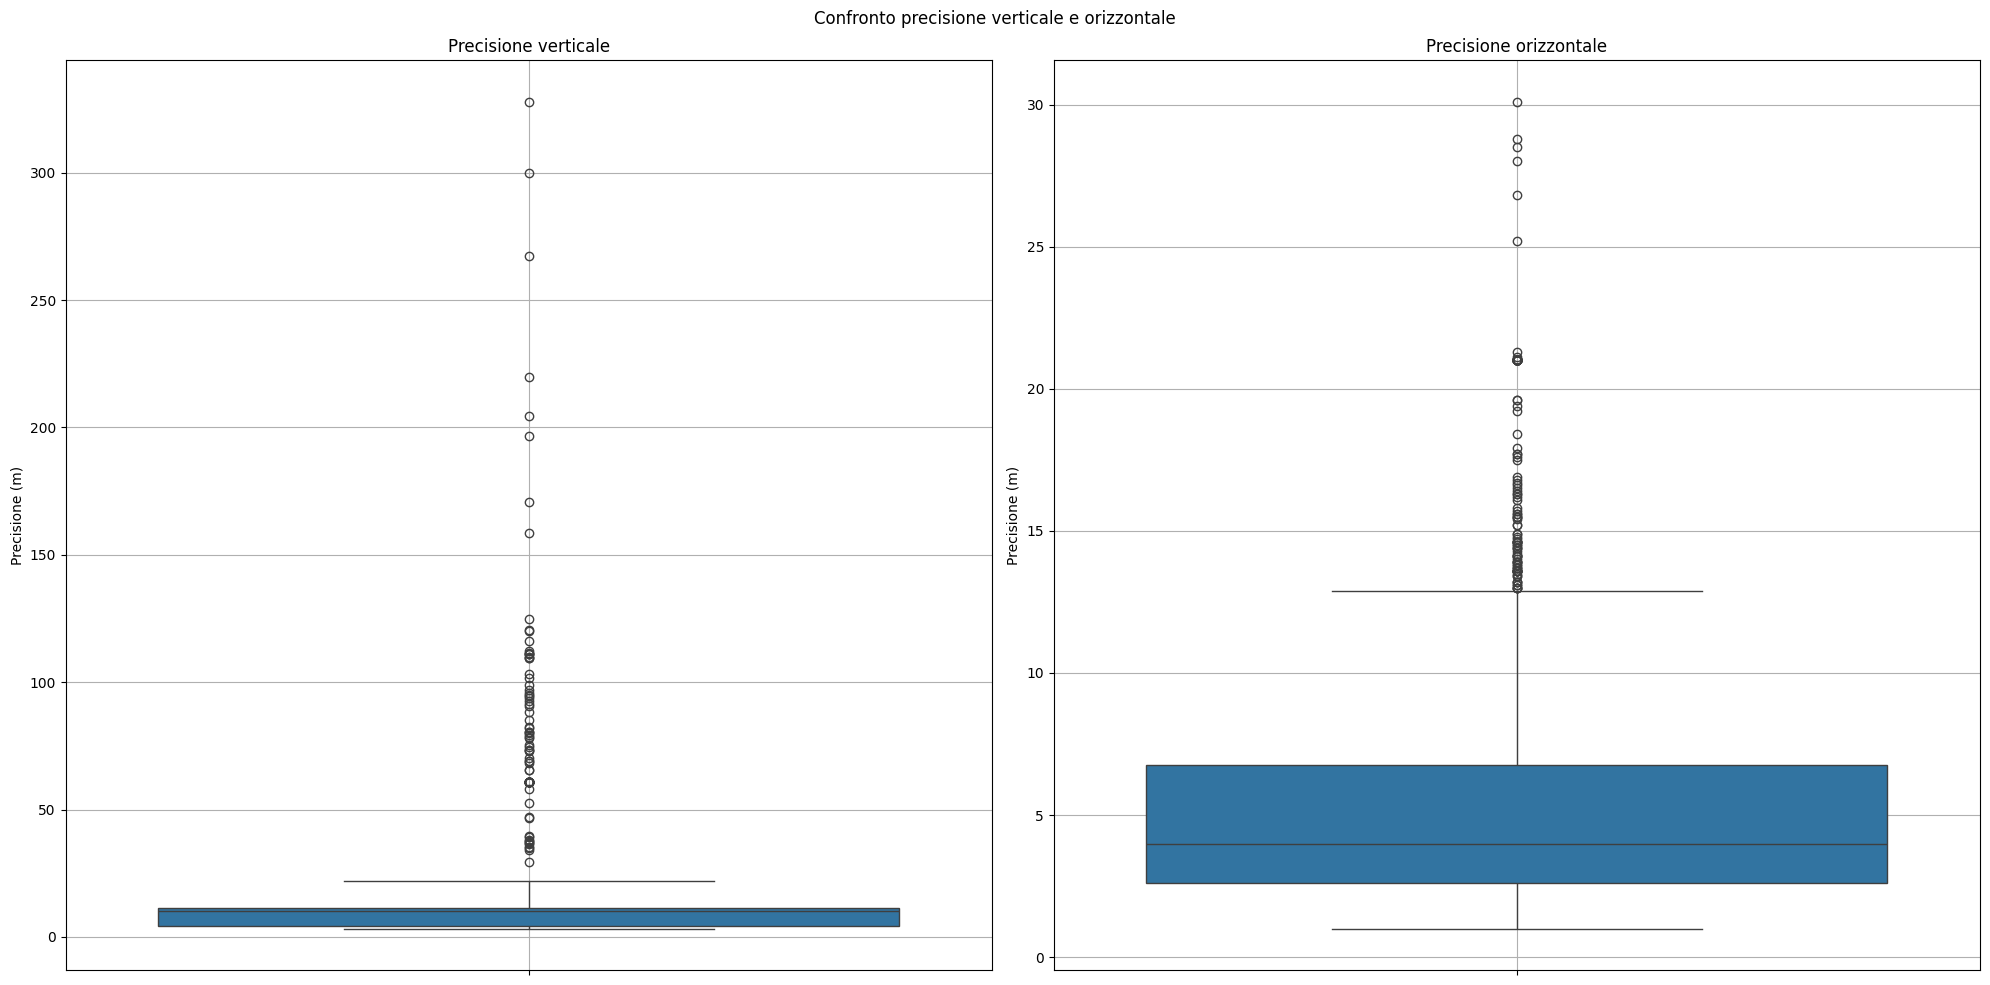

In [5]:
## Le due precisioni comparate

fig, axes = plt.subplots(1, 2, figsize=(20, 10))  ## 1 riga, 2 colonne

fig.suptitle('Confronto precisione verticale e orizzontale')
## precisione_verticale
sns.boxplot(ax=axes[0], y=gdf1['precisione_verticale'])
axes[0].set_title('Precisione verticale')
axes[0].set_ylabel('Precisione (m)')
axes[0].grid()

## precisione_orizzontale
sns.boxplot(ax=axes[1], y=gdf1['precisione_orizzontale'])
axes[1].set_title('Precisione orizzontale')
axes[1].set_ylabel('Precisione (m)')
axes[1].grid()

plt.tight_layout()
plt.show()

In [6]:
## Aggiungono informazioni derivate al dataframe

## Aggiunge colonna "delta_tempo"

def aggiungi_delta_tempo(gdf):
    gdf['delta_tempo'] = abs(gdf['unixtime'].diff()).fillna(0)
    
    return gdf

def aggiungi_delta_distanze(gdf):
    ## calcola la distanza orizzontale (non tiene conto del dislivello)
    gdf['distanza_orizzontale'] = gdf.geometry.distance(gdf.geometry.shift()).fillna(0) # shift: prende punto successivo

    ## calcola la distanza verticale
    gdf['distanza_verticale'] = gdf['altitudine'].diff().fillna(0) ## positiva: sale, negativa scende

    ## calcola la distanza reale 3D usando Pitagora: i = sqrt(c1^2 + c2^2)
    gdf['distanza_reale'] = np.sqrt(
        gdf['distanza_orizzontale']**2 + (gdf['distanza_verticale'])**2
    )

    return gdf

def aggiungi_pendenza(gdf):

    gdf['pendenza'] = np.degrees(np.arctan(gdf['distanza_verticale'] / gdf['distanza_orizzontale']))
    gdf['pendenza'] = gdf['pendenza'].fillna(0)
    
    return gdf

def aggiungi_velocita(gdf):

    gdf['velocita']= (gdf['distanza_reale'] / gdf['delta_tempo']).fillna(0)

    return gdf

def aggiungi_accelerazione(gdf):

    gdf['delta_velocita'] = gdf['velocita'].diff().fillna(0)

    gdf['accelerazione'] = (gdf['delta_velocita'] / gdf['delta_tempo']).fillna(0)
    
    return gdf

def aggiungi_accelerazione_max(gdf):
    # Converti la pendenza da gradi a radianti
    gdf['pendenza_radianti'] = np.radians(gdf['pendenza'])

    # Calcola l'accelerazione massima teorica
    gdf['accelerazione_max'] = 9.81 * np.sin(gdf['pendenza_radianti'])

    return gdf

In [7]:
## Filtri su grandezze primarie
## Questi filtri eliminano dati in base a informazioni primaria(non derivate) nel dataframe
## Poco costosi

def filtro_precisione(gdf, precisione_orizzontale=10, precisione_verticale=10):

    gdf_filtrato = gdf.loc[
        (gdf['precisione_orizzontale'] <= precisione_orizzontale) &
        (gdf['precisione_verticale'] <= precisione_verticale)
    ].reset_index(drop=True)
    
    return gdf_filtrato

def filtra_temporalmente(gdf, min_tempo=1):

    # Lista per le righe da mantenere
    valid_rows = [0]  # Mantieni sempre il primo punto

    # Itera attraverso i punti
    for i in range(1, len(gdf)):
        # Calcola il tempo tra il punto corrente e l'ultimo punto valido
        delta_tempo = gdf.iloc[i]['unixtime'] - gdf.iloc[valid_rows[-1]]['unixtime']
        
        # Se la differenza di tempo è sufficiente, aggiungi il punto alla lista
        if delta_tempo >= min_tempo:
            valid_rows.append(i)
    
    # Filtra il DataFrame
    gdf_filtrato = gdf.iloc[valid_rows].reset_index(drop=True)
    
    return gdf_filtrato

## trova intersezioni geometriche fra punti troppo vicini
## dovrebbe eliminare jitter jps 
def filtro_intersezioni(gdf, max_time_diff=60*1):

    punti_da_rimuovere = []  ## Lista per i punti da rimuovere
    segmenti = [] ## i segmenti che uniscono 2 punti

    ## crea segmenti
    for i in range(len(gdf) - 1):
        ## un segmento è fatto dal punto d'inizio e il punto di fine con relativi timestamp
        punto1 = (gdf.loc[i, "longitudine"], gdf.loc[i, "latitudine"])
        punto2 = (gdf.loc[i + 1, "longitudine"], gdf.loc[i + 1, "latitudine"])
        tempo1 = gdf.loc[i, "unixtime"]
        tempo2 = gdf.loc[i + 1, "unixtime"]

        ## il segmento diventa un tipo LineString
        segmento = LineString([punto1, punto2])

        ## aggiunge il segmento con i timestamp e gli indici
        segmenti.append((   segmento, 
                            tempo1, 
                            tempo2, 
                            i, 
                            i + 1))  

    ## controlla le intersezioni
    for i in range(len(segmenti)):
        j = i + 2   ## partiamo dal segmento successivo, 
                    ## 2 punti più in la per evitare intersezioni in un punto singolo!!!

        while j < len(segmenti) and abs(segmenti[i][2] - segmenti[j][1]) <= max_time_diff:  
            segmento1 = segmenti[i][0]  ## il primo valore della tupla è un segmento
            segmento2 = segmenti[j][0]  

            if segmento1.intersects(segmento2):  ## se si intersecano
                punti_da_rimuovere.append(segmenti[i][4])  ## elimina i punti di indice i e j
                #punti_da_rimuovere.append(segmenti[j][3])  ## [3]: i [4]:i+1 

            j += 1  # Passa al segmento successivo
            ##if
        ##while
    ##for
    ## segmenti intersecanti trovati

    gdf = gdf.drop(punti_da_rimuovere).reset_index(drop=True)

    return gdf


In [8]:
## filtra il df in base ai limiti fisici delle grandezze derivate. 
## COSTOSO

def filtra_df(gdf_orig, min_acc=-4, max_acc=4):

    gdf=gdf_orig.copy() ## gdf.loc[]...

    cambiato = True
    while cambiato:

        gdf = aggiungi_delta_tempo(gdf)
        gdf = aggiungi_delta_distanze(gdf)
        gdf = aggiungi_pendenza(gdf)
        gdf = aggiungi_velocita(gdf)
        gdf = aggiungi_accelerazione(gdf)
        gdf = aggiungi_accelerazione_max(gdf)
        
        lunghezza_pre = len(gdf)
        ## Filtra per accelerazione
        gdf = gdf[(gdf['accelerazione'] >= min_acc) & (gdf['accelerazione'] <= max_acc)]

        lunghezza_post = len(gdf)
        # Se sono state eliminate righe, ripeti il ciclo
        if lunghezza_post < lunghezza_pre:
            cambiato = True
        else:
            cambiato = False

    return gdf

In [9]:
## Filtri dati primari dataset

gdf1 = filtro_precisione(gdf1, precisione_orizzontale=20, precisione_verticale= 20)

gdf1= filtro_intersezioni(gdf1, max_time_diff=60*1)

In [10]:
## Inserimento di grandezze derivate

gdf1 = aggiungi_delta_tempo(gdf1)

gdf1= aggiungi_delta_distanze(gdf1)

gdf1= aggiungi_pendenza(gdf1)

gdf1= aggiungi_velocita(gdf1)

gdf1 = aggiungi_accelerazione(gdf1)

gdf1= aggiungi_accelerazione_max(gdf1)

In [11]:
## Filtro in base alla fisica su grandezze derivate

gdf1= filtra_df(gdf1, min_acc=-3, max_acc=3)

#gdf1.describe()

In [12]:
time_start = gdf1['unixtime'].iloc[0]
time_end = gdf1['unixtime'].iloc[-1]

time_delta= time_end - time_start

tempo_trascorso_hms = str(datetime.timedelta(seconds=time_delta))
#print(tempo_trascorso_hms)


## Il dataset finale

Composto da 3000+ punti gps **originali** a cui sono state aggiunte le informazioni relative a:

- scarto temporale
- velocità
- accelerazione
- distanza fra punti
- ...

Le misurazioni coprono uno span temporale di circa 5 h e mezza.

Questi dati sono più attendibili

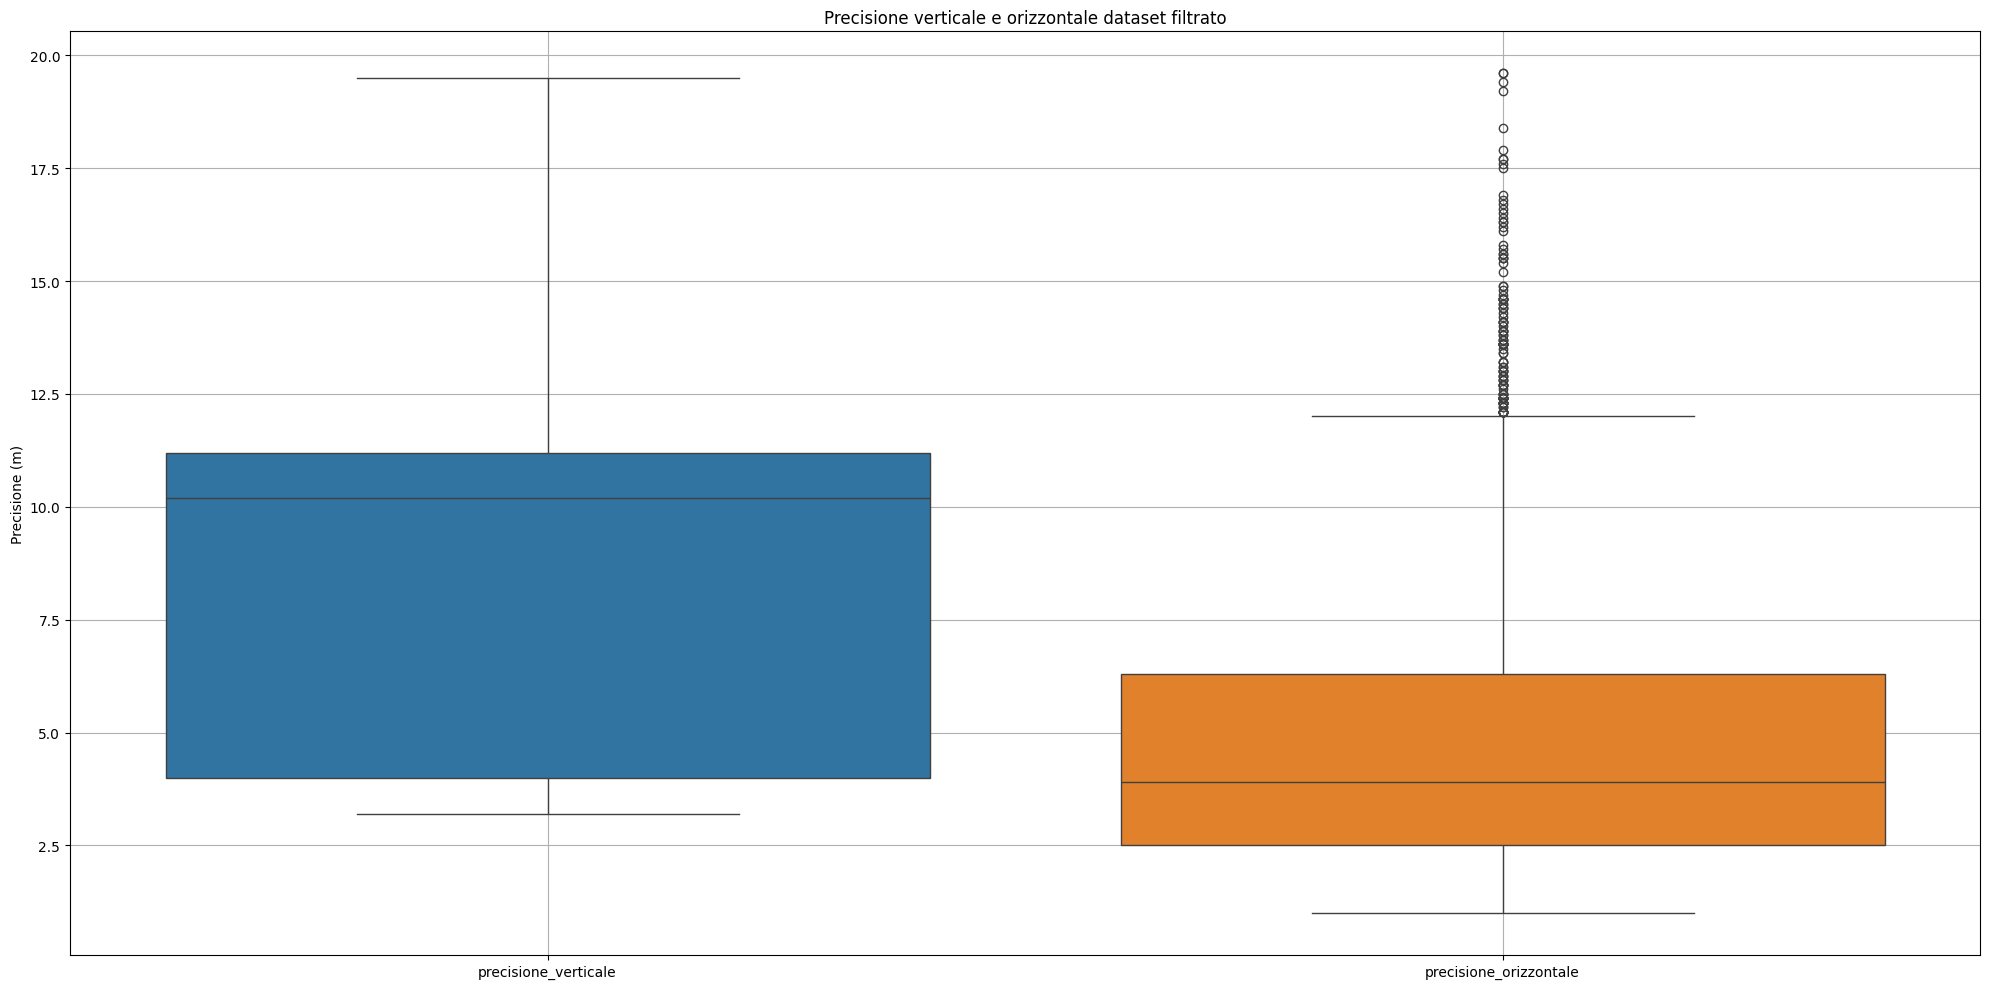

In [13]:
plt.figure(figsize=(20, 10))


sns.boxplot(data=gdf1[['precisione_verticale', 'precisione_orizzontale']])

plt.title('Precisione verticale e orizzontale dataset filtrato')
plt.ylabel('Precisione (m)')
plt.grid()

plt.tight_layout()
plt.show()

## Com'è andata la giornata?

### Il profilo di giornata

Ho registrato 10 discese in un arco temporale di 5 ore e mezza circa (5:28:21).

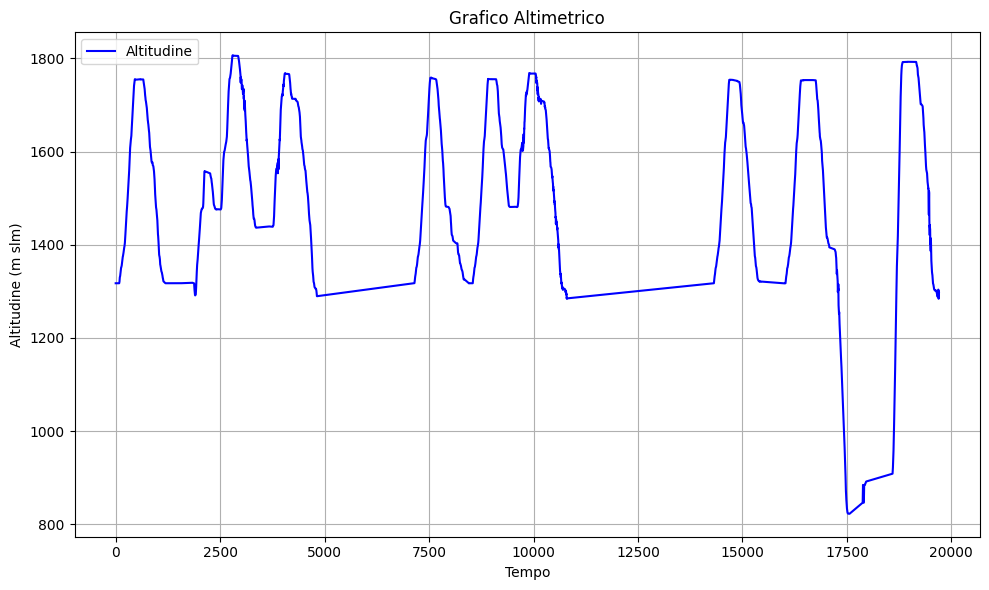

In [14]:
## Altimetria della giornata
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________
## ________________________


plt.figure(figsize=(10, 6)) ##

plt.plot(gdf1['unixtime'] - time_start, 
    gdf1['altitudine'], 
    label='Altitudine', 
    color='blue')

plt.xlabel('Tempo')
plt.ylabel('Altitudine (m slm)')
plt.title('Grafico Altimetrico')
plt.grid()
plt.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()


## Uso del tempo

La giornata è stata divisa in scaglioni temporali etichettati in base all'attività:

- le risalite hanno il nome delle funivie :
  - Cuel D'ajar
  - Valvan
  - Giro d'Italia
  - Ravascletto
- le discese sono clusterizzate in un unico insieme: le piste offrono molte varianti!
- la classificazione "Altro" comprende il tempo utilizzato per:
  - mangiare
  - spostarsi fra gli impianti di risalita
  - tempo in coda

In [15]:
## Analisi temporale

gdf1['stato'] = 'Altro'

## 
for _, row in df_stato.iterrows():
    ## maschera con unixtime
    mask = (gdf1['unixtime'] >= row['unixtime_start']) & (gdf1['unixtime'] <= row['unixtime_end'])
    
    ## lo stato è presente nel df stato
    gdf1.loc[mask, 'stato'] = row['stato']




In [16]:

tempo_per_stato = gdf1.groupby('stato')['delta_tempo'].sum().reset_index()
tempo_per_stato.columns = ['stato', 'tempo_totale']

conteggio_stati = df_stato['stato'].value_counts().reset_index()
conteggio_stati.columns= [ 'stato', 'conteggio']


tempo= pd.merge(conteggio_stati, tempo_per_stato, on='stato', how='right').fillna(0)

tempo['tempo_medio']= tempo['tempo_totale'] / tempo['conteggio']
tempo['tempo_percentuale']= (tempo['tempo_totale'] / time_delta) * 100

tempo['tempo_totale_minuti'] = tempo['tempo_totale']/ 60

tempo['tempo_medio_minuti'] = tempo['tempo_medio'] / 60


## calocolo tempo totale in risalita
tempo_risalite = tempo[tempo['stato'] != 'Altro']

tempo_risalite= tempo_risalite[tempo_risalite['stato']!= 'Discesa']

## Calcolare il tempo totale in risalita
tempo_totale_risalite = tempo_risalite['tempo_totale'].sum()

#print(tempo_totale_risalite)
#print(str(datetime.timedelta(seconds=tempo_totale_risalite)))
#print(str(datetime.timedelta(seconds=5858)))



tempo.head(10)


,stato,conteggio,tempo_totale,tempo_medio,tempo_percentuale,tempo_totale_minuti,tempo_medio_minuti
0,Altro,0.0,9730.0,inf,49.388356,162.166667,inf
1,Cuel d’Ajar,1.0,257.0,257.0,1.304502,4.283333,4.283333
2,Discesa,10.0,5858.0,585.8,29.734531,97.633333,9.763333
3,Giro d’Italia,3.0,933.0,311.0,4.735800,15.550000,5.183333
4,Ravascletto,1.0,874.0,874.0,4.436323,14.566667,14.566667
5,Valvan,5.0,2049.0,409.8,10.400487,34.150000,6.830000


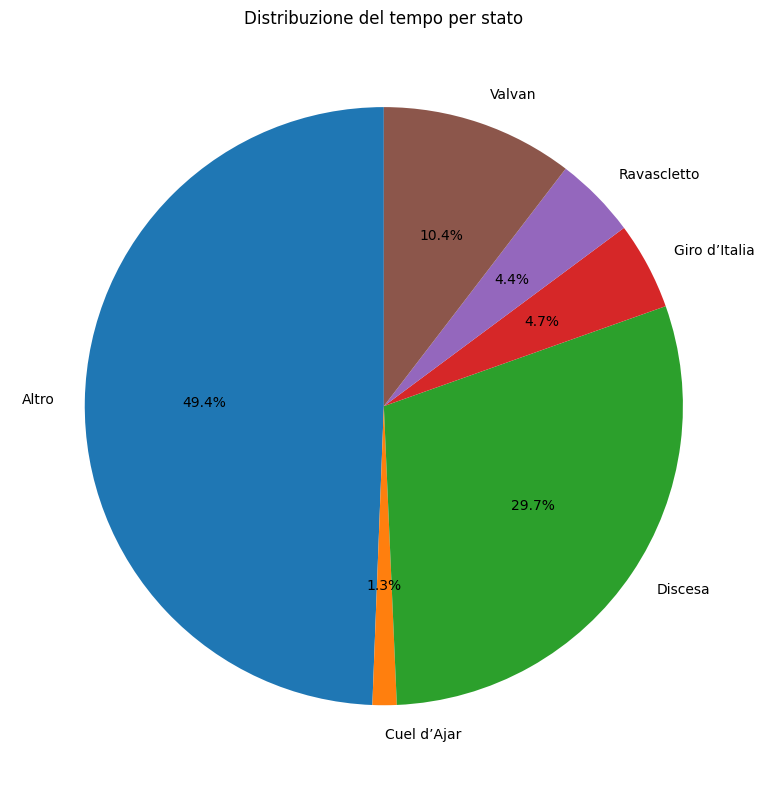

In [17]:
## piechart per non impbrogliare nessuno
plt.figure(figsize=(15, 8))

plt.title('Distribuzione del tempo per stato')

plt.pie(tempo['tempo_totale'], 
        labels=tempo['stato'], 
        autopct='%1.1f%%', 
        startangle=90)

plt.tight_layout()
plt.show()

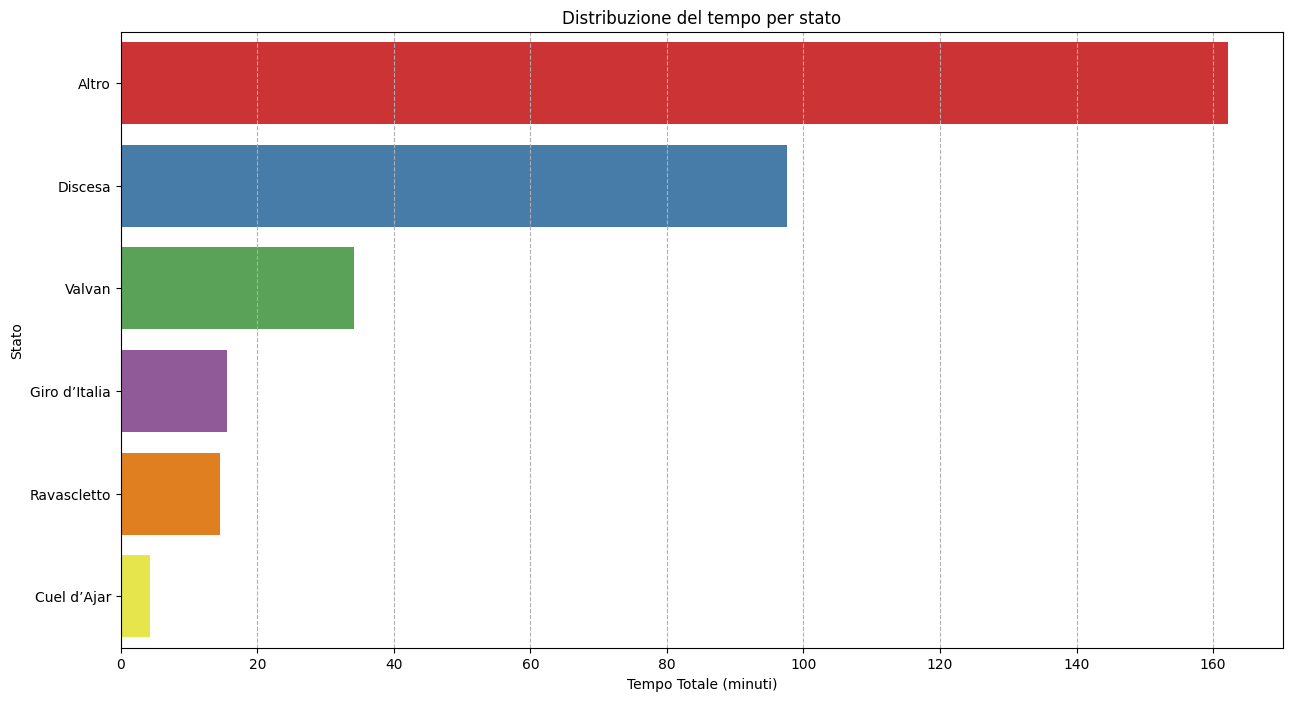

In [18]:

tempo_sorted = tempo.sort_values(by='tempo_totale_minuti', ascending=False)

plt.figure(figsize=(15, 8))
plt.title('Distribuzione del tempo per stato')

sns.barplot(data=tempo_sorted, 
                 y='stato', 
                 x='tempo_totale_minuti', 
                 hue='stato',
                 palette='Set1')

plt.xlabel('Tempo Totale (minuti)')
plt.ylabel('Stato')
plt.grid( axis='x',linestyle='--')

plt.show()


Non sembro molto sportivo: il 49.4% è stato impiegato per fare altro, mentre solo il 29.7% del tempo è stato utilizzato per scendere...

Il tempo speso per salire ammonta a ben 1:08:33.



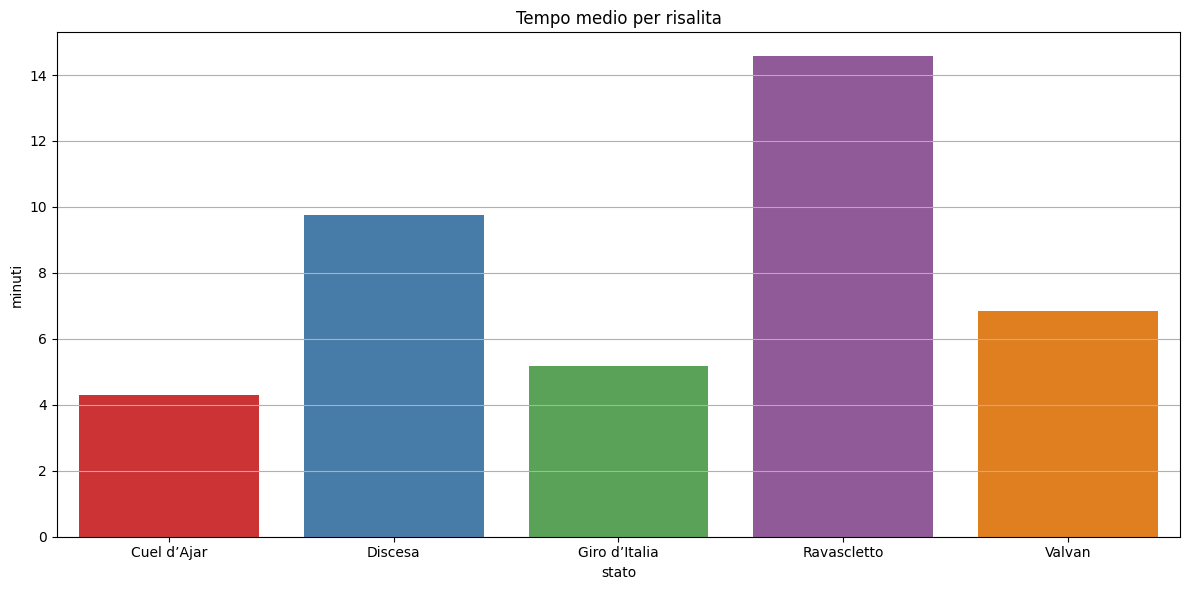

In [19]:
tempo_attivo = tempo[tempo['stato'] != 'Altro']

#
plt.figure(figsize=(12, 6))

plt.title('Tempo medio per risalita')

sns.barplot(data=tempo_attivo, 
            x='stato', 
            y='tempo_medio_minuti', 
            hue='stato',
            palette='Set1'
            )

plt.ylabel('minuti')

plt.grid(plt.grid( axis='x',
        linestyle='--'))
plt.tight_layout()
plt.show()



1:09:06


### Quanto ho pagato per stare in coda

// TROVA IL TEMPO DELLE SALITE E DIVIDILO PER IL PREZZO SKIPASS
// TROVA I PUNTI VICINI ALLE SALITE PER STIMARE I TEMPO DI ATTESA

## Più pendente = più veloce

// MAPPA CON VELOCITA
// CALCOLA COEFFICIENTE D'ATTRITO

## tempo risalita vs tempo discesa per ogni pista